<a href="https://colab.research.google.com/github/alejogiley/Hack7/blob/master/Unqualified_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Anaconda

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')
#ignore warning about PYTHONPATH

In [0]:
import os
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Stats
from scipy.stats import skew

#Importing scikit-learn
import sklearn as sk
#Fill---
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.preprocessing import Imputer
#Normalizing
from sklearn import preprocessing
#Data split
from sklearn.model_selection import train_test_split 
#Random Forest packages
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
#Evaluation package
from sklearn.metrics import accuracy_score

#Importing XG_BOOST packages
import xgboost as xg
from xgboost import plot_importance

#Importing Neural Network Packages
from sklearn.neural_network import MLPClassifier

#Importing rdkit packages
from rdkit import RDConfig
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#Importing DeepChem
import deepchem as dc

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# Load Dataset
df = pd.read_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_Pyrrolamides_4OE.csv', encoding='unicode_escape') 
df.head()

,External_ID,Molecule SMILES,First Sample Reg. Date,SAU Gyr IC50 (µM),SAU Gyr Ki (µM),Sau516 MIC (µg/ml),Sau516 MIC (µM),Mean Human Prot binding (% free),Mean LogD,Determination of pKa HA1,Determination of pKa HA2,Determination of pKa B1,Determination of pKa B2,Sirius pKa
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],6/10/2002,>400,NaN,>64,NaN,NaN,NV,NaN,NaN,NaN,NaN,NaN
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,8/16/2002,>50,NaN,>64,NaN,NaN,>4,NaN,NaN,NaN,NaN,NaN
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,8/16/2002,7.14,NaN,>64,NaN,NaN,>3.66,NaN,NaN,NaN,NaN,NaN
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,8/16/2002,9.93,NaN,>64,NaN,NaN,>3.13,NaN,NaN,NaN,NaN,NaN
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,8/16/2002,3.31,NaN,>64,NaN,NaN,>4.07,NaN,NaN,NaN,NaN,NaN


In [37]:
# Get Mol objects 
#[Chem.MolFromSmiles(x) for x in pp['Molecule SMILES'].values.tolist()]
pp['smiles'] = df['Molecule SMILES']
pp['mol'] = pp['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3ncc(s3)C=O)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OCC=C)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)C(=O)NC)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NC)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4COC)Cl)Cl'
RDKit ERROR: [15:14:58] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4[nH]ccn4)Cl)Cl'
RDKit ERROR: [15:14:58] SMILE

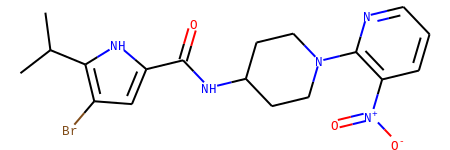

In [38]:
#Now let's see what we've got
pp['mol'][1]

In [0]:
# Get Descriptors
